In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from tensorflow.python import keras as keras

In [2]:
# load data
hmmtc = pd.read_csv('test_new.csv')
hmmtc[['LoanNo.','Closed']] = hmmtc[['LoanNo.','Closed']].astype(int)
hmmtc = hmmtc.set_index('LoanNo.')
hmmtc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3354 entries, 59871 to 58034
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FundingSource   3354 non-null   object 
 1   LTV             3354 non-null   float64
 2   State           3354 non-null   object 
 3   LoanProcessor   3354 non-null   object 
 4   LoanOfficer     3354 non-null   object 
 5   LoanAmount      3354 non-null   float64
 6   AppraisedValue  3354 non-null   float64
 7   Closed          3354 non-null   int64  
 8   TimeWindow      3354 non-null   float64
dtypes: float64(4), int64(1), object(4)
memory usage: 262.0+ KB


<AxesSubplot:ylabel='Frequency'>

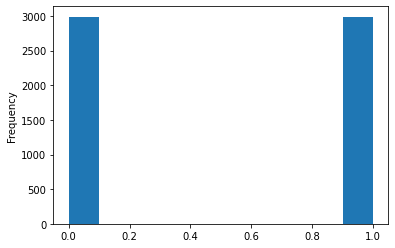

In [3]:
# count
count1, count0 = hmmtc['Closed'].value_counts()
#count1, count0
closed = hmmtc[hmmtc.Closed==1]
withdraw = hmmtc[hmmtc.Closed==0]

# resample
overwd = withdraw.sample(count1, replace=True)
oversample = pd.concat([closed,overwd], axis=0)
oversample['Closed'].plot.hist()

In [4]:
y=oversample.Closed
X=oversample.drop(['Closed'],axis=1)
# DictVectorizer
#from sklearn.feature_extraction import DictVectorizer
# instantiate a Dictvectorizer object for X
#vec = DictVectorizer() 
#X = X.to_dict(orient='records')
#X = vec.fit_transform(X).toarray()

In [5]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=25)

In [6]:
fc = tf.feature_column
NUMERIC_COLUMNS = ('LTV', 
           'LoanAmount', 
           'AppraisedValue',  
           'TimeWindow')
CATEGORICAL_COLUMNS = ('FundingSource', 
           'State', 
           'LoanProcessor', 
           'LoanOfficer')
def one_hot_cat_column(feature_name, vocab):
  return tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                                vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = X_train[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))
for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                                          dtype=tf.float32))

In [7]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).    
    dataset = dataset.repeat(n_epochs)
    # In memory training doesn't use batching.
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn
# Training and evaluation input functions.
train_input_fn = make_input_fn(X_train, y_train)
eval_input_fn = make_input_fn(X_test, y_test, shuffle=False, n_epochs=1)

In [14]:
params = {
  'n_trees': 300,
  'max_depth': 5,
  'learning_rate':0.3,
  'n_batches_per_layer': 1,
  # You must enable center_bias = True to get DFCs. This will force the model to 
  # make an initial prediction before using any features (e.g. use the mean of 
  # the training labels for regression or log odds for classification when
  # using cross entropy loss).
  'center_bias': True
}
est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
# Train model.
est.train(train_input_fn, max_steps=50)
# Evaluation.
results = est.evaluate(eval_input_fn)
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**results))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp71vw8i8q', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp71vw8i8q', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tm

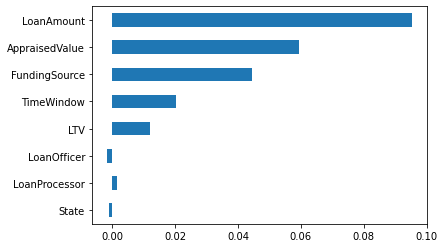

In [15]:
# Make predictions.
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
# Plot results.
ID = 182
example = df_dfc.iloc[ID]  # Choose ith example from evaluation set.
TOP_N = 8  # View top 8 features.
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = example[sorted_ix].plot(kind='barh')

In [16]:
pred_dicts[0]
final_predictions = []
for pred in pred_dicts:
    final_predictions.append(pred['class_ids'][0])

In [17]:
# Evaluations
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print('Classification Reprt: \n')
print(classification_report(y_test,final_predictions))
print('\nConfusion Matrix: \n')
print(confusion_matrix(y_test,final_predictions))

Classification Reprt: 

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       726
           1       0.86      0.84      0.85       769

   micro avg       0.84      0.84      0.84      1495
   macro avg       0.84      0.84      0.84      1495
weighted avg       0.84      0.84      0.84      1495


Confusion Matrix: 

[[619 107]
 [126 643]]


In [67]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=8, activation='relu'))
model.add(tf.keras.layers.Dense(units=1))

In [51]:
model = tf.keras.Sequential([
    keras.layers.Flatten(input_shape=(8, 8)),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1)
    ])

In [68]:
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(0.1))

In [69]:
trained_model = model.fit(X_train, y_train, epochs=100, verbose=False)
print("Finished training the model")

Finished training the model
